In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [29]:
data = pd.read_csv('../../dataset/deceptive-opinion.csv/deceptive-opinion.csv')
# Keeping only the neccessary columns
data = data[['text','polarity','deceptive']]
data['text'] = data['text'].map(lambda text: text if type(text)!=str else text.lower())

In [30]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.3)

train = train[train.polarity != "Neutral"]
train_pos = train[ train['polarity'] == 'positive']
train_pos = train_pos['text']
train_neg = train[ train['polarity'] == 'negative']
train_neg = train_neg['text']
train.loc[train.polarity == 'negative', 'polarity'] = 0
train.loc[train.polarity == 'positive', 'polarity'] = 1
train.loc[train.deceptive == 'deceptive', 'deceptive'] = 0
train.loc[train.deceptive == 'truthful', 'deceptive'] = 1
test.loc[test.deceptive == 'deceptive', 'deceptive'] = 0
test.loc[test.deceptive == 'truthful', 'deceptive'] = 1
test.loc[test.polarity == 'negative', 'polarity'] = 0
test.loc[test.polarity == 'positive', 'polarity'] = 1

C:\Users\varun\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\varun\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\varun\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\varun\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarni

In [31]:
X_train = train['text'].values
X_test = test['text'].values
y_train = train['deceptive'].astype(int)
y_train_polarity = train['polarity'].astype(int)
y_test = test['deceptive'].astype(int)
y_test_polarity = test['polarity'].astype(int)

Positive words


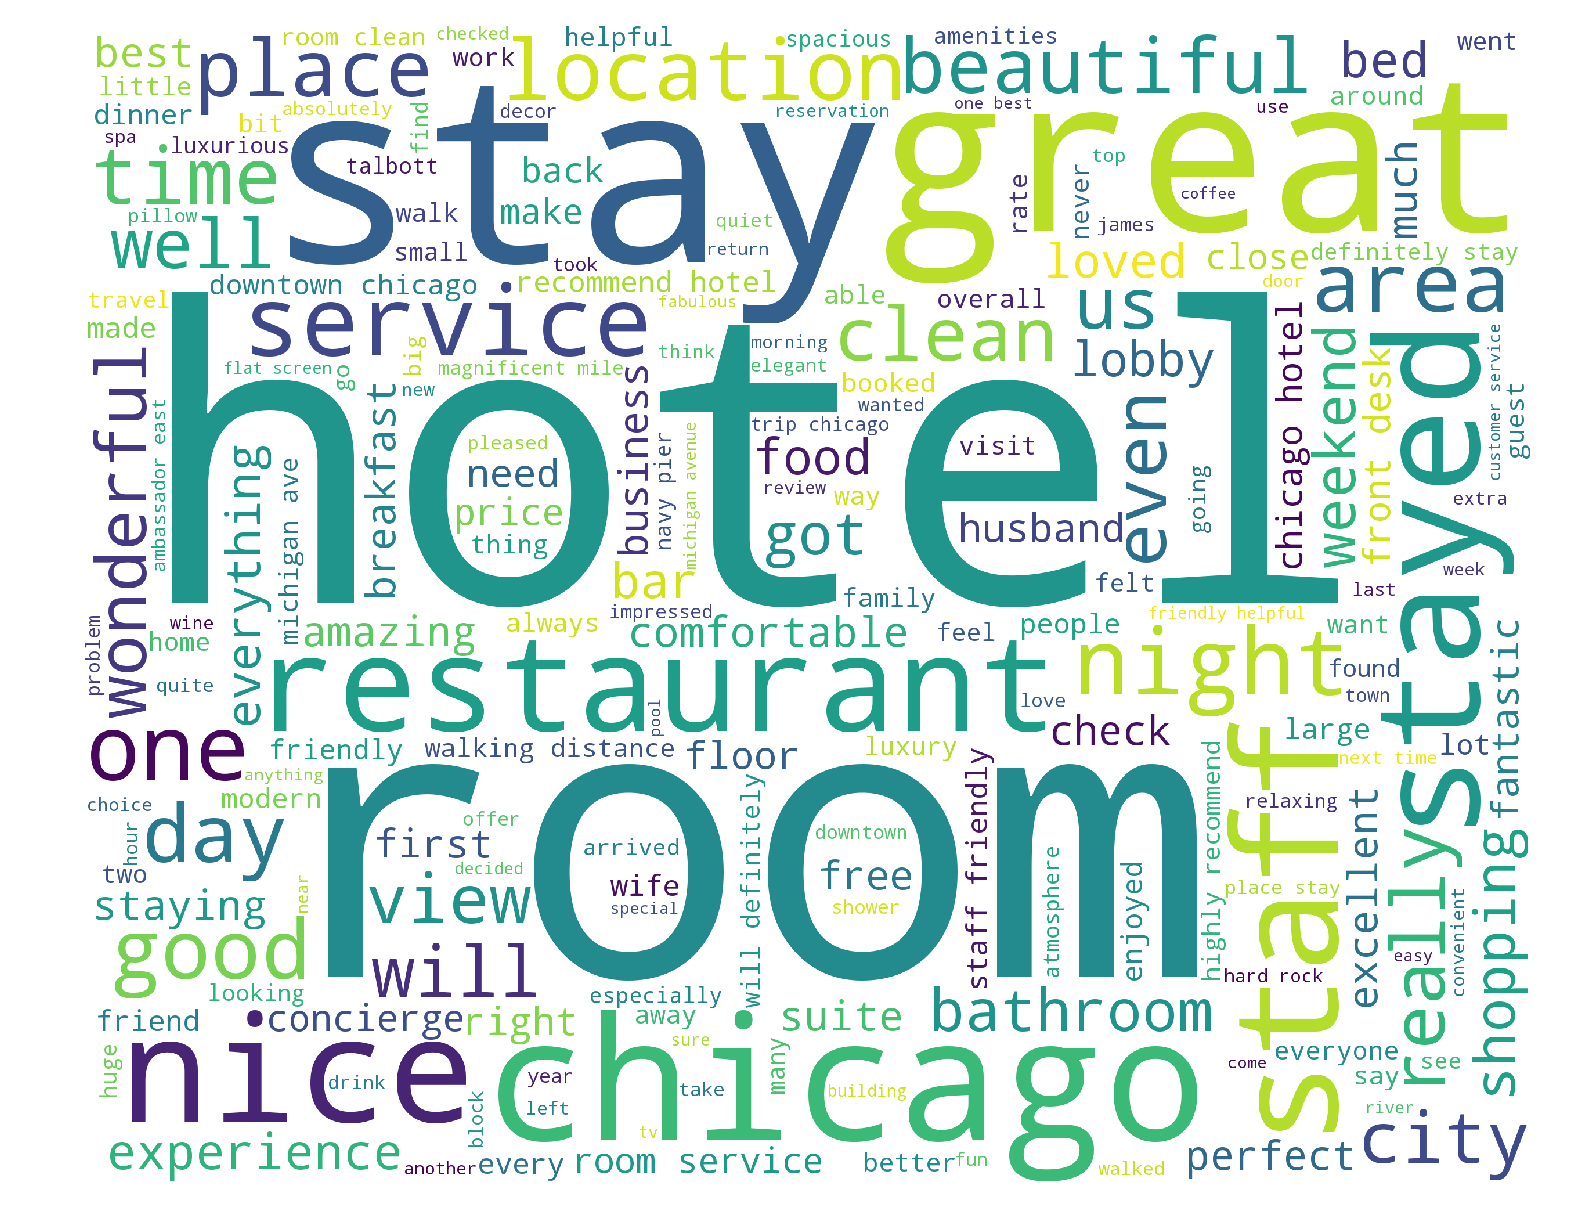

Negative words


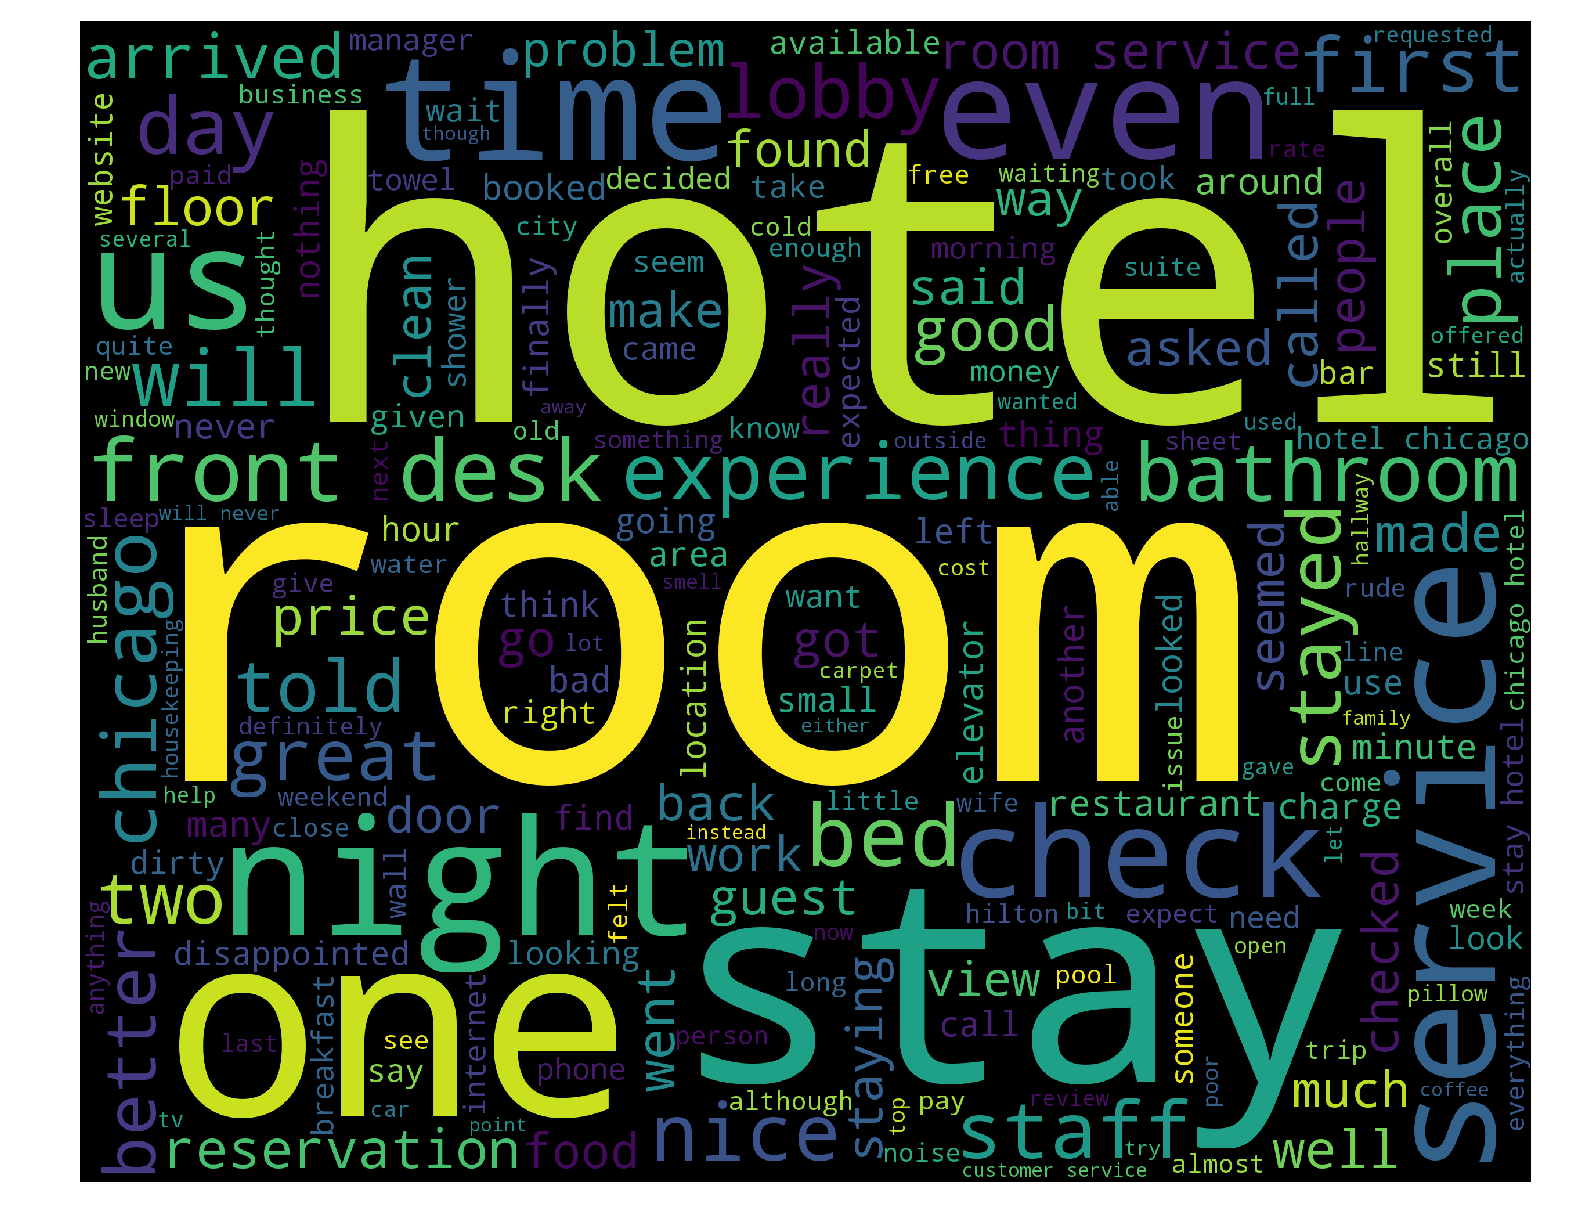

In [32]:


def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [33]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [34]:
kfolds = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)

In [35]:
pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   50.4s finished


0.9372035238310369

In [36]:
# Create feature vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import time
from sklearn.metrics import classification_report
vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)


# Perform classification with SVM, kernel=rbf
classifier_rbf = svm.SVC(kernel='rbf')
t0 = time.time()
classifier_rbf.fit(train_vectors, y_train)
t1 = time.time()
prediction_rbf = classifier_rbf.predict(test_vectors)
t2 = time.time()
time_rbf_train = t1-t0
time_rbf_predict = t2-t1



# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1


# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
t0 = time.time()
classifier_liblinear.fit(train_vectors, y_train)
t1 = time.time()
prediction_liblinear = classifier_liblinear.predict(test_vectors)
t2 = time.time()
time_liblinear_train = t1-t0
time_liblinear_predict = t2-t1


# Print results in a nice table
print("Results for SVC(kernel=rbf)")
print("Training time: %fs; Prediction time: %fs" % (time_rbf_train, time_rbf_predict))
print(classification_report(y_test, prediction_rbf))

print("Results for SVC(kernel=linear)")
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
print(classification_report(y_test, prediction_linear))

print("Results for LinearSVC()")
print("Training time: %fs; Prediction time: %fs" % (time_liblinear_train, time_liblinear_predict))
print(classification_report(y_test, prediction_liblinear))

Results for SVC(kernel=rbf)
Training time: 0.982000s; Prediction time: 0.394000s
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       247
          1       0.49      1.00      0.65       233

avg / total       0.24      0.49      0.32       480

Results for SVC(kernel=linear)
Training time: 0.673000s; Prediction time: 0.270000s
             precision    recall  f1-score   support

          0       0.89      0.86      0.88       247
          1       0.86      0.89      0.88       233

avg / total       0.88      0.88      0.88       480

Results for LinearSVC()
Training time: 0.009000s; Prediction time: 0.001000s
             precision    recall  f1-score   support

          0       0.89      0.85      0.87       247
          1       0.85      0.89      0.87       233

avg / total       0.87      0.87      0.87       480



C:\Users\varun\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
grid_svm.best_score_

0.9332261204300678

In [38]:
model = grid_svm.best_estimator_
pred = model.predict(X_test)
f1 = f1_score(y_test, pred)
print f1

0.8706896551724137


In [39]:
X_temp = []
y_temp = []
for i in range(len(X_test)):
    if(pred[i] == 1):
        X_temp.append(X_test[i])
        y_temp.append(y_test_polarity.iloc[i])
print len(X_temp)
print len(y_temp)
        

231
231


In [40]:
pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=1) 

grid_svm.fit(X_train, y_train_polarity)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   49.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.8, max_features=None, min_df=5,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smoo...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svc__C': [0.01, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=1)

In [41]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [42]:
report_results(grid_svm.best_estimator_, X_temp, y_temp)

{'acc': 0.9523809523809523,
 'auc': 0.97976011994003,
 'f1': 0.9523809523809523,
 'precision': 0.9565217391304348,
 'recall': 0.9482758620689655}

In [43]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [44]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_temp, y_temp)

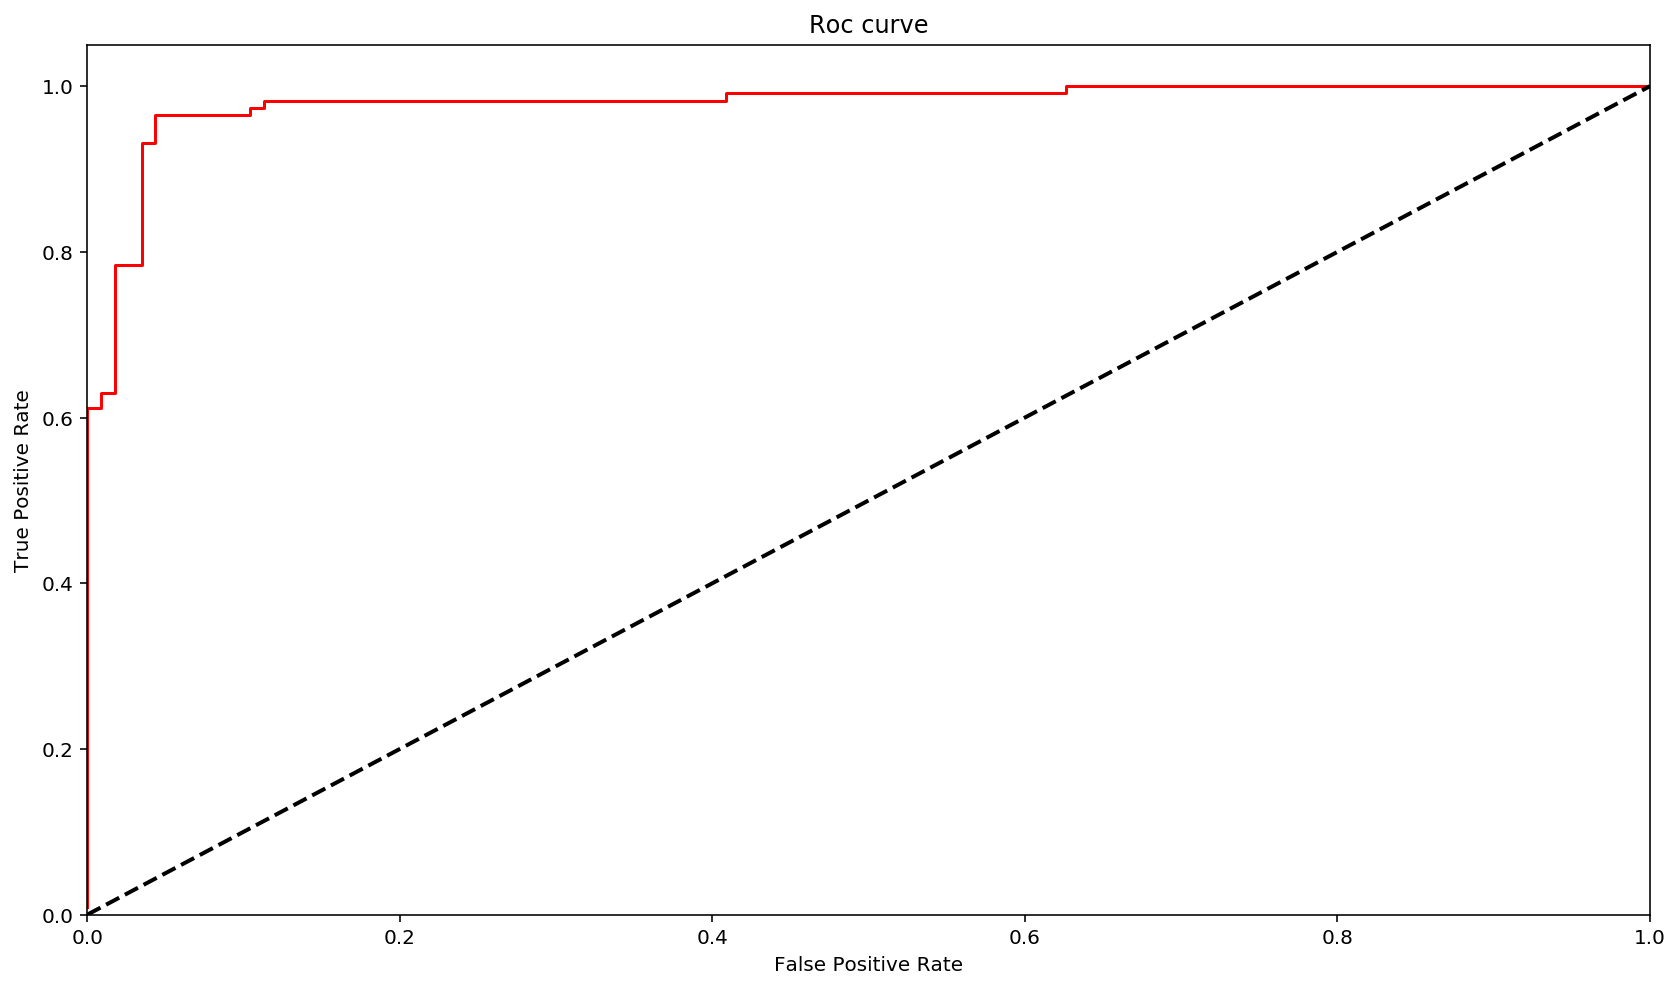

In [45]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [46]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train_polarity, cv=5, n_jobs=1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [47]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

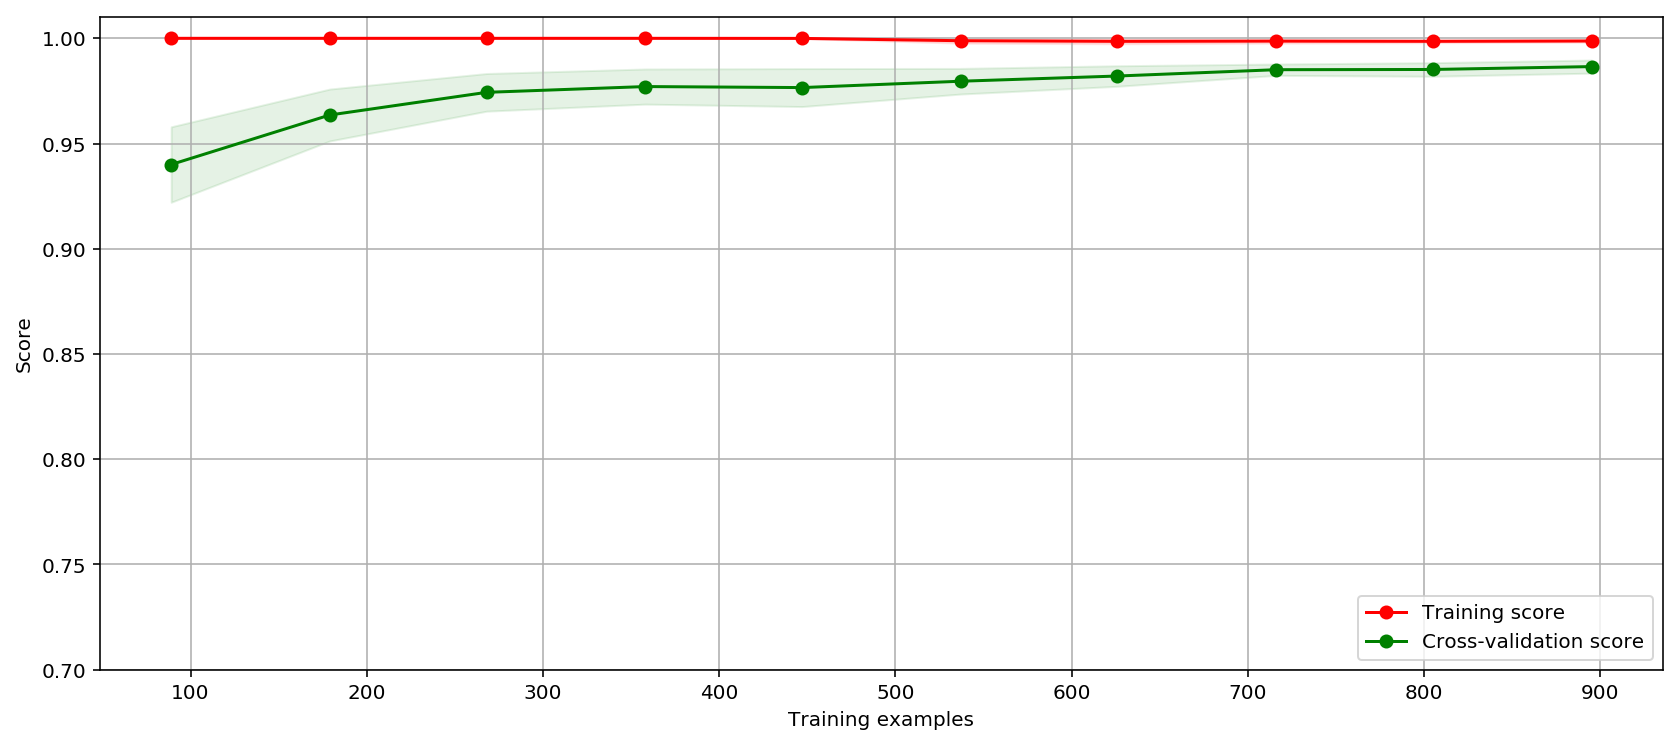

In [48]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()